In [8]:
import earthaccess,csv
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from scipy.ndimage import generic_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.ndimage import median_filter
# %pip install utm
# import utm
from scipy.interpolate import LinearNDInterpolator

Following cells are requirements for packages from meom group (jaxparrow and widetrax)

In [9]:
conda install -c conda-forge libgl #Need to run this on the first time to install meom group packages

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
 - pytorch
 - eumetsat
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.3.0
    latest version: 25.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - libgl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.12.14 |       hbcca054_0         153 KB  conda-forge
    certifi-2024.12.14         |     pyhd8ed1ab_0         158 KB  conda-forge
    libgl-1.7.0                |       ha4b6fd6_0         130 KB  conda-forge
    libglvnd-1.7.0             |       ha4b6fd6_0         126 KB  conda-forge
    libglx-1.7.0               |       ha4b6fd6_0          77 KB  conda-forge
    openssl-3.3.1     

In [10]:
conda install conda-forge::pyinterp 

Channels:
 - conda-forge
 - defaults
 - pytorch
 - eumetsat
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.3.0
    latest version: 25.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - conda-forge::pyinterp


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libboost-1.86.0            |       hf299e74_1         2.8 MB  conda-forge
    libopenblas-0.3.28         |pthreads_h94d23a6_0         5.3 MB  conda-forge
    openblas-0.3.28            |pthreads_h6ec200e_0         5.5 MB  conda-forge
    pyinterp-2024.6.0          |openblas_py310h06e7549_101         4.1 MB  conda-forge
    ------------------------------------------------------------
                                           To

In [11]:
%pip install jaxparrow
from jaxparrow import cyclogeostrophy
import jax.numpy as jnp
import jaxparrow as jxr

Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install widetrax
import widetrax

Note: you may need to restart the kernel to use updated packages.


In [13]:
from widetrax import Spectra as sp
from widetrax import DataPreprocessing as dp
from widetrax import Grads as gr

In [14]:
# %pip install haversine
# import haversine as hs   
# from haversine import Unit

In [15]:
# Set default fontsizes for plots
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

In [16]:
def get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax):
    """
    Searches for SWOT data within the bounding box and time. Note that this doesn't work for unsmoothed data. 
    
    latmin,latmax: latitude bounds, degrees N (south is negative); floats
    lonmin, lonmax: longitude bounds, degrees E (west is negative); floats
    tmin,tmax: temporal bounds; strings of form 'yyyy-mm-dd'
    """
    bbox = (lonmin, latmin, lonmax, latmax) # lonW, latS, lonE, latN
    results = earthaccess.search_data(
        short_name="SWOT_L2_LR_SSH_EXPERT_2.0",
        bounding_box=bbox,
        temporal=(tmin,tmax))
    
    print("Number of swaths: " + str(len(results))) # not daily files, so will likely be more than # of days
    paths = earthaccess.open(results) # is there a way to choose a subset of variables here?

    return paths

In [17]:
latmin,latmax = 34,38
lonmin,lonmax = -73,-68
tmin,tmax = '2024-04-03','2024-08-05' #'2024-04-17','2024-08-04'

edward_paths = get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax)

Number of swaths: 84


QUEUEING TASKS | :   0%|          | 0/84 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/84 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/84 [00:00<?, ?it/s]

In [18]:
date_requested = '20240508'

ind = 0 
for i in edward_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if date_requested == today:
        print(ind)
    ind += 1

23
24


In [19]:
ds1 = xr.open_dataset(edward_paths[23])
ds2 = xr.open_dataset(edward_paths[24])

In [20]:
def crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.latitude >= latmin) & (ds.latitude <= latmax) & (ds.longitude >= lonmin+360) & (ds.longitude <= lonmax+360)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [21]:
ds1_masked = crop_dataset_by_lat_lon(ds1,latmin,latmax,lonmin,lonmax)
ds2_masked = crop_dataset_by_lat_lon(ds2,latmin,latmax,lonmin,lonmax)

In [22]:
# Quick velocities: need to change
xv = np.arange(287, 293, 0.036)
yv = np.arange(33,39, 0.036)
grid_x, grid_y = np.meshgrid(xv, yv)

def quick_velocities(ds, grid_x, grid_y):
    ssh=ds.ssha_karin_2+ds.height_cor_xover
    lats=ds.latitude
    lons=ds.longitude
    grid_ssh = griddata((lons.values.ravel(),lats.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')
    return grid_ssh

In [23]:
def compute_geos_current(ssh,lat):
    """
    ssh: (m) Make sure this is first corrected with height_cor_xover from L2 data! 
    lat: degrees N
    """
    
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
        
    # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    dx,dy = 4000,4000 # m i changed it to 4000 to match res? need to double check
    gravity = 9.81

    dsdy,dsdx=np.array(np.gradient(ssh, dx, edge_order=1))
    vg = (gravity/np.array(f_coriolis))*dsdx
    ug = -(gravity/np.array(f_coriolis))*dsdy
    geos_current = np.sqrt(ug**2 + vg**2)
    
    return ug,vg,geos_current

In [24]:
grid_ssh1 = quick_velocities(ds1_masked, grid_x, grid_y)
grid_ssh2 = quick_velocities(ds2_masked, grid_x, grid_y)

In [25]:
#Calculate
ug1,vg1,geos_current1 = compute_geos_current(grid_ssh1,grid_y)
ug2,vg2,geos_current2 = compute_geos_current(grid_ssh2,grid_y)

In [26]:
# plt.clf()

# fig,ax=plt.subplots(figsize=(8,5))
# plot = ax.pcolormesh(grid_x,grid_y,ug1,cmap='coolwarm',vmin=-1,vmax=1)
# plot = ax.pcolormesh(grid_x,grid_y,ug2,cmap='coolwarm',vmin=-1,vmax=1)
# cbar = plt.colorbar(plot,ax=ax)

# cbar.set_label('ug (m/s)', rotation=270, labelpad=15)

# ax.set_ylabel('Latitude (N$^{\circ}$)')
# ax.set_xlabel('Longitude (E$^{\circ}$)')
# ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

# plt.show()

# plt.clf()

# fig,ax=plt.subplots(figsize=(8,5))
# plot = ax.pcolormesh(grid_x,grid_y,vg1,cmap='coolwarm',vmin=-1,vmax=1)
# plot = ax.pcolormesh(grid_x,grid_y,vg2,cmap='coolwarm',vmin=-1,vmax=1)

# cbar = plt.colorbar(plot,ax=ax)

# cbar.set_label('vg (m/s)', rotation=270, labelpad=15)

# ax.set_ylabel('Latitude (N$^{\circ}$)')
# ax.set_xlabel('Longitude (E$^{\circ}$)')
# ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

# plt.show()

In [27]:
np.shape(ug1)

(167, 167)

In [ ]:
np.shape(lats)


In [ ]:
np.shape(ug1_reg)

In [29]:
#Regrid to diagonal
ds=ds1_masked
lats=ds.latitude
lons=ds.longitude
# grid_ssh = griddata((lons.values.ravel(),lats.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')

ug1_reg = griddata((grid_x.ravel(),grid_y.ravel()), ug1.ravel(), ((lons,lats)), method='linear')
vg1_reg = griddata((grid_x.ravel(),grid_y.ravel()), vg1.ravel(), ((lons,lats)), method='linear')
ug2_reg = griddata((grid_x.ravel(),grid_y.ravel()), ug2.ravel(), ((lons,lats)), method='linear')
vg2_reg = griddata((grid_x.ravel(),grid_y.ravel()), vg2.ravel(), ((lons,lats)), method='linear')

(33.8, 38.0)

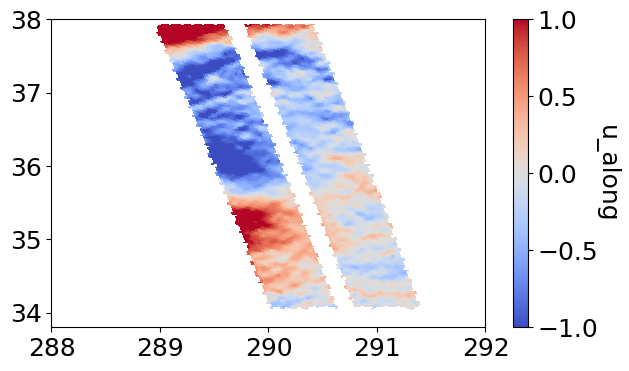

In [30]:
fig,ax=plt.subplots(figsize=(7,4))
plot = ax.pcolormesh(lons, lats, ug1_reg, shading='auto',cmap='coolwarm',vmin=-1,vmax=1)  # 'shading' option can adjust how cells are rendered
# plot = ax.pcolormesh(grid_x, grid_y, ug2, shading='auto',cmap='coolwarm',vmin=-1,vmax=1)  # 'shading' option can adjust how cells are rendered
cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('u_along', rotation=270, labelpad=15)
# ax.axis('equal')
ax.set_xlim([288,292])
ax.set_ylim([33.8,38])

In [ ]:
lons

In [ ]:
dy

In [ ]:
dx

In [57]:
def compute_vort_strain(ug, vg, lon, lat):
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
    # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    dx,dy = 4000, 4000 # m
    # dx, dy = jxr.tools.geometry.compute_spatial_step(lon, lat)
    du_dy, du_dx = np.gradient(ug, dx, edge_order=2)
    dv_dy, dv_dx = np.gradient(vg, dx, edge_order=2)
    
    ksi = (dv_dx - du_dy)/f_coriolis
    sigma= np.sqrt((du_dx - dv_dy)**2 + (du_dy + dv_dx) ** 2)
    sigma=sigma/f_coriolis 
    
    return ksi, sigma

(33.8, 38.0)

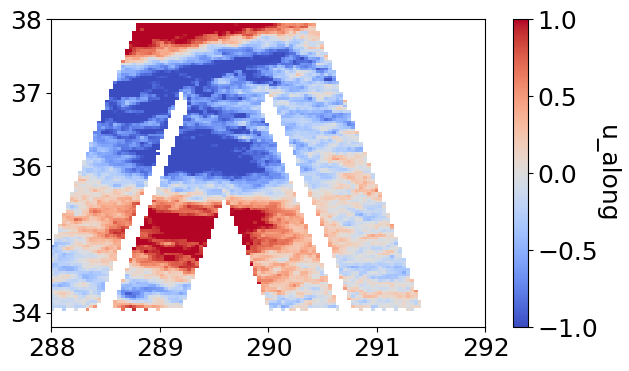

In [38]:
fig,ax=plt.subplots(figsize=(7,4))
plot = ax.pcolormesh(grid_x, grid_y, ug1, shading='auto',cmap='coolwarm',vmin=-1,vmax=1)  # 'shading' option can adjust how cells are rendered
# plot = ax.pcolormesh(lons, lats, ug1_reg, shading='auto',cmap='coolwarm',vmin=-1,vmax=1)  # 'shading' option can adjust how cells are rendered
plot = ax.pcolormesh(grid_x, grid_y, ug2, shading='auto',cmap='coolwarm',vmin=-1,vmax=1)  # 'shading' option can adjust how cells are rendered
cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('u_along', rotation=270, labelpad=15)
# ax.axis('equal')
ax.set_xlim([288,292])
ax.set_ylim([33.8,38])

In [43]:
wfl=5
ug_smooth1=xr.apply_ufunc(generic_filter,ug1, np.mean, [wfl,wfl])
vg_smooth1=xr.apply_ufunc(generic_filter,vg1, np.mean, [wfl,wfl])
ug_smooth2=xr.apply_ufunc(generic_filter,ug2, np.mean, [wfl,wfl])
vg_smooth2=xr.apply_ufunc(generic_filter,vg2, np.mean, [wfl,wfl])

In [58]:
ksi, sigma =compute_vort_strain(ug_smooth1,vg_smooth1,grid_x,grid_y)
ksi2, sigma2 =compute_vort_strain(ug_smooth2,vg_smooth2,grid_x,grid_y)

(33.8, 38.0)

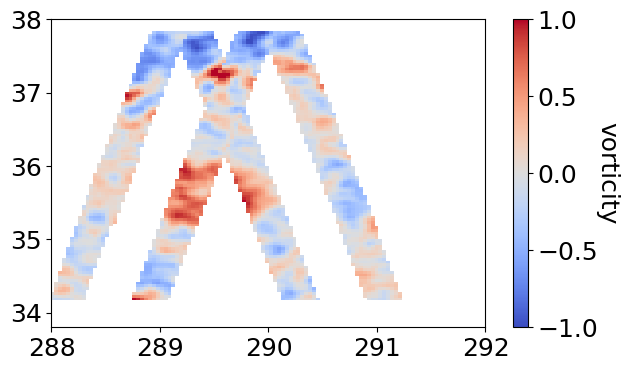

In [45]:
fig,ax=plt.subplots(figsize=(7,4))
plot = ax.pcolormesh(grid_x,grid_y,ksi, shading='auto',cmap='coolwarm',vmin=-1,vmax=1)  # 'shading' option can adjust how cells are rendered
plot = ax.pcolormesh(grid_x, grid_y, ksi2, shading='auto',cmap='coolwarm',vmin=-1,vmax=1)  # 'shading' option can adjust how cells are rendered
cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('vorticity', rotation=270, labelpad=15)
# ax.axis('equal')
ax.set_xlim([288,292])
ax.set_ylim([33.8,38])

(33.8, 38.0)

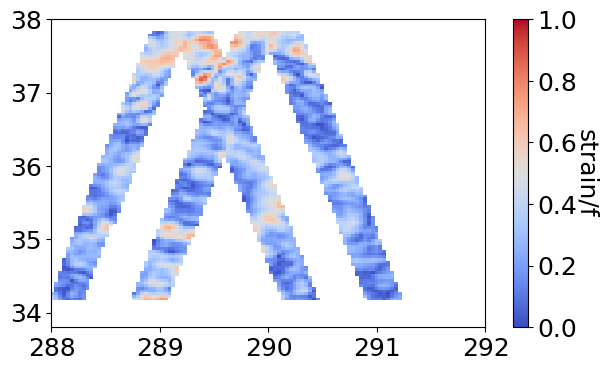

In [59]:
fig,ax=plt.subplots(figsize=(7,4))
plot = ax.pcolormesh(grid_x,grid_y,sigma, shading='auto',cmap='coolwarm',vmin=0,vmax=1)  # 'shading' option can adjust how cells are rendered
plot = ax.pcolormesh(grid_x, grid_y, sigma2, shading='auto',cmap='coolwarm',vmin=0,vmax=1)  # 'shading' option can adjust how cells are rendered
cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('strain/f', rotation=270, labelpad=15)
# ax.axis('equal')
ax.set_xlim([288,292])
ax.set_ylim([33.8,38])

In [ ]:
# # Compute derivatives
# dx, dy = jxr.tools.geometry.compute_spatial_step(lons.values, lats.values)
# mask = np.zeros_like(ug1_reg)
# mask2 = np.zeros_like(ug2_reg)

# wfl=5
# ug_smooth1=xr.apply_ufunc(generic_filter,ug1_reg, np.mean, [wfl,wfl])
# vg_smooth1=xr.apply_ufunc(generic_filter,vg1_reg, np.mean, [wfl,wfl])
# ug_smooth2=xr.apply_ufunc(generic_filter,ug2_reg, np.mean, [wfl,wfl])
# vg_smooth2=xr.apply_ufunc(generic_filter,vg2_reg, np.mean, [wfl,wfl])

# dv_dx1 = jxr.tools.operators.derivative(vg_smooth1, dx, mask=mask, axis=1, padding="right")  # ∂v/∂x
# du_dy1 = jxr.tools.operators.derivative(ug_smooth1, dy, mask=mask, axis=0, padding="right")  # ∂u/∂y
# dv_dx2 = jxr.tools.operators.derivative(vg_smooth2, dx, mask=mask2, axis=1, padding="right")  # ∂v/∂x
# du_dy2 = jxr.tools.operators.derivative(ug_smooth2, dy, mask=mask2, axis=0, padding="right")  # ∂u/∂y

# # # Compute vorticity: ∂v/∂x - ∂u/∂y
# vorticity_f = dv_dx - du_dy
# vorticity_f2 = dv_dx2 - du_dy2

# # du_dy, du_dx = np.gradient(ug_smooth1, dx, edge_order=2)
# # dv_dy, dv_dx = np.gradient(vg_smooth1, dx, edge_order=2)

# # vorticity_f = (dv_dx - du_dy)/f_coriolis

# lat=lats.values;
# omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
# fc = 2*omega*np.sin(lat*np.pi/180.)
    
# # avoid zero near equator, bound fc by min val as 1.e-8
# f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)

# vorticity_f=vorticity_f/f_coriolis
# vorticity_f2=vorticity_f2/f_coriolis

In [47]:
# dataset=ds1_masked
# lat_t = jnp.array(dataset.latitude.values)
# lon_t = jnp.array(dataset.longitude.values)
# # ssh_t = jnp.array(dataset.ssh.values)
# ssh_t = jnp.array(dataset.ssha_karin_2.values+dataset.height_cor_xover.values)

# u_geos_u, v_geos_v, *_ = jxr.geostrophy(ssh_t, lat_t, lon_t, return_grids=True)

In [48]:
# dx, dy = jxr.tools.geometry.compute_spatial_step(ds1_masked.latitude.values, ds1_masked.longitude.values)

In [49]:
# # modify widetrax
# import jax.numpy as jnp
# import jaxparrow as jxr
# #from WIDETRAX:

# def compute_vorticity_1_ds(dataset):
#     """
#     Compute the vorticity from a single xarray dataset.

#     Parameters
#     -----------
#     dataset : xarray.Dataset
#         Dataset containing geophysical variables like `ssha`, `ssh`, or `ssh_filtered`.
#     variable_name : str
#         The name of the variable to use for calculation. Default is "ssha".
#     mask : np.ndarray, optional 
#         Mask array indicating zones to exclude (1 for land, 0 for ocean).
#         If None, a zero array is used.


#     Returns
#     --------
#     vorticity_f : np.ndarray
#         2D array of vorticity.
#     """
    
#     # if variable_name not in dataset:
#     #     raise ValueError(f"The dataset does not contain the variable '{variable_name}'.")

#     # # Handle the case where the variable is already "ssh"
#     # if variable_name != "ssh":
#     #     dataset["ssh"] = dataset[variable_name] + dataset.get("mdt", 0)  # Use "mdt" if it exists, else assume 0
#     # else:
#     #     dataset["ssh"] = dataset[variable_name]

#     # ssh=ds2_masked.ssha_karin_2+ds2_masked.height_cor_xover

#     lat_t = jnp.array(dataset.latitude.values)
#     lon_t = jnp.array(dataset.longitude.values)
#     # ssh_t = jnp.array(dataset.ssh.values)
#     ssh_t = jnp.array(dataset.ssha_karin_2.values+dataset.height_cor_xover.values)

#     # Compute spatial steps dx and dy
#     dx, dy = jxr.tools.geometry.compute_spatial_step(lat_t, lon_t)

#     # Compute geostrophic velocities
#     u_geos_u, v_geos_v, *_ = jxr.geostrophy(ssh_t, lat_t, lon_t, return_grids=True)

#     # Initialize mask if not provided
#     # if mask is None:
#     mask = np.zeros_like(u_geos_u)

#     # Compute derivatives
#     dv_dx = jxr.tools.operators.derivative(v_geos_v, dx, mask=mask, axis=1, padding="right")  # ∂v/∂x
#     du_dy = jxr.tools.operators.derivative(u_geos_u, dy, mask=mask, axis=0, padding="right")  # ∂u/∂y

#     # Compute vorticity: ∂v/∂x - ∂u/∂y
#     vorticity_f = dv_dx - du_dy

#     return vorticity_f

In [ ]:
# vort=compute_vorticity_1_ds(ds1_masked)

In [ ]:
# ds1_masked

In [ ]:
# lat=ds1_masked.latitude;
# omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
# fc = 2*omega*np.sin(lat*np.pi/180.)
    
# # avoid zero near equator, bound fc by min val as 1.e-8
# f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)